In [ ]:
%pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ridhamswamii","key":"3ef3569167cac3d81b9683379f1b45c8"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d bhaveshmittal/melanoma-cancer-dataset

Dataset URL: https://www.kaggle.com/datasets/bhaveshmittal/melanoma-cancer-dataset
License(s): CC0-1.0
 73% 58.0M/79.4M [00:00<00:00, 107MB/s]
100% 79.4M/79.4M [00:00<00:00, 117MB/s]


In [ ]:
!unzip melanoma-cancer-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/Malignant/1530.jpg  
  inflating: train/Malignant/1531.jpg  
  inflating: train/Malignant/1532.jpg  
  inflating: train/Malignant/1533.jpg  
  inflating: train/Malignant/1534.jpg  
  inflating: train/Malignant/1535.jpg  
  inflating: train/Malignant/1536.jpg  
  inflating: train/Malignant/1537.jpg  
  inflating: train/Malignant/1538.jpg  
  inflating: train/Malignant/1539.jpg  
  inflating: train/Malignant/154.jpg  
  inflating: train/Malignant/1540.jpg  
  inflating: train/Malignant/1541.jpg  
  inflating: train/Malignant/1542.jpg  
  inflating: train/Malignant/1543.jpg  
  inflating: train/Malignant/1544.jpg  
  inflating: train/Malignant/1545.jpg  
  inflating: train/Malignant/1546.jpg  
  inflating: train/Malignant/1547.jpg  
  inflating: train/Malignant/1548.jpg  
  inflating: train/Malignant/1549.jpg  
  inflating: train/Malignant/155.jpg  
  inflating: train/Malignant/1550.jpg  
  inflating: train/Malignant/15

In [ ]:
# Imports
import torch
import torch.nn as nn
import torch.optim  as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Setting device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Image Size
imgSize = 112

# Transformations
# Training transformer
transformer = transforms.Compose([
    transforms.RandomRotation(degrees = 20),

    transforms.RandomHorizontalFlip(p = 0.3),
    transforms.RandomVerticalFlip(p = 0.3),

    transforms.Resize(size = (imgSize, imgSize), antialias = True),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

# Validation transformer
valTransformer = transforms.Compose([
    transforms.Resize(size = (imgSize, imgSize), antialias = True),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [ ]:
# hyperparameters
BATCH_SIZE = 64
epochs = 5
learning_rate = 0.001

In [ ]:
path = '/content/train/'
valPath = '/content/test/'

# Reading data
trainData = datasets.ImageFolder(root = path, transform = transformer)
testData = datasets.ImageFolder(root = valPath, transform = valTransformer)

train_loader = DataLoader(dataset=trainData,batch_size= BATCH_SIZE, shuffle= True)
test_loader = DataLoader(dataset=testData, batch_size= BATCH_SIZE, shuffle= False)

In [ ]:
model = torchvision.models.efficientnet_b7(weights= torchvision.models.EfficientNet_B7_Weights.IMAGENET1K_V1)
model.classifier[1] = nn.Linear(2560, 2)
print(model.classifier)

Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:01<00:00, 165MB/s]


Sequential(
  (0): Dropout(p=0.5, inplace=True)
  (1): Linear(in_features=2560, out_features=2, bias=True)
)


In [ ]:
# Send model to gpu
print(device)
model.to(device)
# Loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= 8, verbose=True, factor=0.1)

cuda


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [ ]:
def check_accuracy(loader, model, Train= True):
    if Train:
        print('Checking accuracy on training data')
    else:
        print('Checking accuracy on test data')
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
    acc = float(num_correct/float(num_samples))
    print(f'{num_correct}/{num_samples} with accuracy {float(num_correct/float(num_samples))*100:.2f}')
    model.train()
    return acc

In [ ]:
# Early Stopping
patience = 5
minDelta = 0.01
currentPatience = 0
bestLoss = float('inf')

In [ ]:
for epoch in range(epochs):
    model.train()
    runningLoss = 0.0
    loop = tqdm(enumerate(train_loader), total= len(train_loader), leave= False)
    for batch_idx, (data, targets) in loop:
        # Send data to device
        data = data.to(device)
        targets = targets.to(device)
        # forward
        scores = model(data)
        loss = criterion(scores, targets)
        #backprop
        optimizer.zero_grad()
        loss.backward()
        #log
        runningLoss += loss.item()
        #otimizer
        optimizer.step()
        # update progress bar
        loop.set_description(f'Epoch [{epoch}/{epochs}]')
        loop.set_postfix(loss = loss.item())
    trainLoss= runningLoss/len(train_loader)
    if trainLoss < bestLoss - minDelta:
        bestLoss = trainLoss
        currentPatience = 0
    else:
        currentPatience += 1
    if currentPatience >= patience:
        print('Early stopping triggered.')
        break

    scheduler.step(trainLoss)
    check_accuracy(train_loader, model, Train=True)

Checking accuracy on training data
10620/11879 with accuracy 89.40


Checking accuracy on training data
10706/11879 with accuracy 90.13


Checking accuracy on training data
11063/11879 with accuracy 93.13


Checking accuracy on training data
11062/11879 with accuracy 93.12


Checking accuracy on training data
11254/11879 with accuracy 94.74


In [ ]:
check_accuracy(train_loader, model, Train= True)
check_accuracy(test_loader, model, Train= False)

Checking accuracy on training data
11224/11879 with accuracy 94.49
Checking accuracy on test data
1849/2000 with accuracy 92.45


0.924500048160553

In [ ]:
def calculate_classification_metrics(loader, model):
    true = []
    preds = []
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            scores = model(x)
            _, predictions = scores.max(1)
            true.extend(y.to('cpu'))
            preds.extend(predictions.to('cpu'))
    print(sklearn.metrics.classification_report(true, preds, digits=5))
    conf_matrix = confusion_matrix(true, preds)
    sns.heatmap(conf_matrix, annot=True,annot_kws={"size": 12},fmt='g', cbar=False, cmap="viridis")
    plt.show()

              precision    recall  f1-score   support

           0    0.90085   0.95400   0.92666      1000
           1    0.95112   0.89500   0.92221      1000

    accuracy                        0.92450      2000
   macro avg    0.92598   0.92450   0.92443      2000
weighted avg    0.92598   0.92450   0.92443      2000



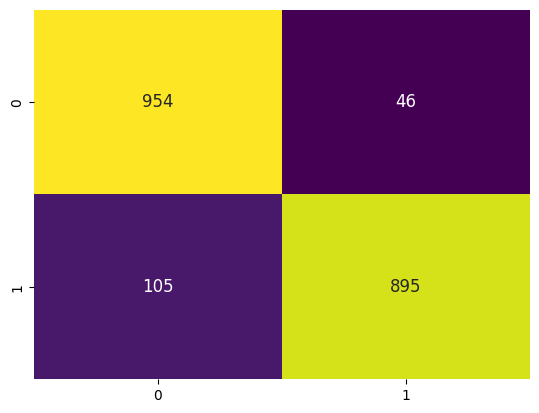

In [ ]:
calculate_classification_metrics(test_loader, model)

In [ ]:
!pip install streamlit torch torchvision pillow pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 85.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 13.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64

In [ ]:
torch.save(model.state_dict(),'model.pth')

In [ ]:
%%writefile app.py
import streamlit as st
from pyngrok import ngrok
import streamlit as st
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

# Define your model architecture (should match the one used during training)
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(32 * 112 * 112, 2)  # Adjust dimensions based on your model

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 32 * 112 * 112)  # Adjust dimensions based on your model
        x = self.fc1(x)
        return x

# Load the saved model
model = SimpleCNN()

# Load the pre-trained weights
pretrained_weights = torch.load('model.pth', map_location=torch.device('cpu'))

# Filter out unnecessary keys with detailed logging
model_state_dict = model.state_dict()
filtered_weights = {k: v for k, v in pretrained_weights.items() if k in model_state_dict}

# Load the weights that match
model.load_state_dict(filtered_weights, strict=False)

model.eval()

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Streamlit UI
st.title("Skin Cancer Detection")
st.write("Upload an image of the skin lesion:")

uploaded_file = st.file_uploader("Choose an image...", type="jpg")

if uploaded_file is not None:
    # Display the uploaded image
    image = Image.open(uploaded_file)
    st.image(image, caption='Uploaded Image', use_column_width=True)

    # Preprocess the image
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension

    # Make a prediction
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        prediction = "Malignant" if predicted.item() == 1 else "Benign"

    st.write(f"Prediction: **{prediction}**")


Writing app.py


In [ ]:
!wget -q -O - ipv4.icanhazip.com
# Run the Streamlit app
!streamlit run app.py & npx localtunnel --port 8501

34.27.92.212



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.27.92.212:8501

npx: installed 22 in 1.532s
your url is: https://gentle-glasses-argue.loca.lt
